<a href="https://colab.research.google.com/github/ancestor9/2025_Spring_Data-Management/blob/main/week_11/AI_Tutor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **🎯 BKT란?**

### **Bayesian Knowledge Tracing (BKT)** 는 학생이 문제를 푸는 행위를 관찰하면서, **어떤 개념(스킬)을 알고 있는지(혹은 아직 모르는지)** 를 **베이즈 확률 모델**을 통해 추적하는 알고리즘이다.

### BKT는 **개별 개념별로 학습자의 지식 상태 `P(Know)` 를 지속적으로 갱신**한다.

---

## 🔍 핵심 개념

- BKT는 각 개념(concept)을 **이진 상태**로 가정한다:

  - ✅ 알고 있음 (`Know`)
  - ❌ 모름 (`Not Know`)

- 학생은 문제를 풀면서 다음과 같은 행동을 보일 수 있다:
  - 알고 있는 개념도 실수로 틀릴 수 있다 (`Slip`)
  - 모르는 개념도 찍어서 맞출 수 있다 (`Guess`)
  - 문제를 통해 개념을 학습할 수 있다 (`Learn`)

---

## 📊 **예측 변수 Parameters**

| 파라미터     | 의미                                          |
|--------------|-----------------------------------------------|
| `p_init`     | 초기 지식 수준 (처음부터 알고 있을 확률)     |
| `p_learn`    | 문제를 통해 새로 배울 확률                    |
| `p_guess`    | 모름에도 불구하고 정답을 맞출 확률           |
| `p_slip`     | 알고 있음에도 실수로 오답을 낼 확률          |

---


## ✅ 요약

- BKT는 **실시간 학생 진단**과 **맞춤형 문제 추천**에 매우 적합함
- 이해하기 쉽고, 적은 데이터로도 작동
- 해석 가능성이 높은 **화이트박스 모델**

> 💡 실제 문제풀이 로그 + `P(Know)` 추정값을 기록하며 분석하는 데 매우 유용




- 학생은 처음에는 대부분 모른다고 가정 (P(Know) 20%), 맞출 확률은 20%
- 문제를 풀면서 학습(30% 확률로 숙지됨)
- 찍어서 맞출 확률이 25% (4지선다에서 현실적 수치)
- 아는 것도 가끔 틀릴 수 있음 (5% 실수 확률), 20문제에서 1개는 실수로


| 상황            | 판단 포인트      | 관련 파라미터   |
| ------------- | ----------- | --------- |
| 정답을 맞췄을 때     | 운으로 맞췄는가?   | `p_guess` |
| 오답을 냈을 때      | 실수였는가?      | `p_slip`  |
| 문제 풀이 후 배웠는가? | 학습 전이 여부    | `p_learn` |
| 초기 상태는?       | 개념 알고 시작했나? | `p_init`  |

<img src='https://miro.medium.com/v2/resize:fit:839/1*uivjxg-_jmSpFqxwWH80DA.png'>

# <font color='orange'> **1. 학생 수준진단 모델 정의**

## 학생이 문제를 풀었을 경우 맞췄을지/틀렸을지에 따라,
### "실제로 이 개념을 알고 있었는지?" (정답이든 오답이든 알고 있었는지?)
- p_know_given_obs

### 문제 풀이를 통해 "이번에 새롭게 배웠는지?" (몰랐지만 배웠는지?)
- (1 - p_know_given_obs) * self.p_learn

### 를 추론해서 P(Know) 값을 갱신해주는 역할
- p_know_given_obs + (1 - p_know_given_obs) * self.p_learn

📌 **정답을 맞췄을 때의 확률 계산 요약 (Bayesian Knowledge Tracing)**

| 항목                       | 수식                                                                 | 의미                                      |
|--------------------------|----------------------------------------------------------------------|-----------------------------------------|
| 알고 있어서 맞췄을 확률        | $$p_{\text{know}} \cdot (1 - \text{slip})$$                            | 알고 있는데 실수하지 않고 맞춘 경우               |
| 몰랐는데 찍어서 맞춘 확률      | $$(1 - p_{\text{know}}) \cdot \text{guess}$$                           | 몰랐지만 찍어서 맞춘 경우                    |
| 분자 (num)               | $$p_{\text{know}} \cdot (1 - \text{slip})$$                            | 정답일 확률의 분자                        |
| 분모 (den)               | $$p_{\text{know}} \cdot (1 - \text{slip}) + (1 - p_{\text{know}}) \cdot \text{guess}$$ | 전체 정답일 확률                         |
| 정답 시 업데이트된 확률       | $$\frac{\text{num}}{\text{den}}$$                                     | 새로운 $$P(\text{Know} \mid \text{Correct})$$ |
| 학습 효과 반영             | $$\frac{\text{num}}{\text{den}} + (1 - p_{\text{know}}) \cdot p_{\text{learn}}$$ | 문제를 통해 새로 배운 경우까지 반영한 최종 확률     |



In [ ]:
# ----------------------------
# BKT 클래스 정의
# ----------------------------
class BKT:
    def __init__(self, p_init=0.2, p_learn=0.3, p_guess=0.25, p_slip=0.05):
        self.p_init = p_init
        self.p_learn = p_learn
        self.p_guess = p_guess
        self.p_slip = p_slip

    def update(self, p_know, is_correct):
        # ----------------------------
        # 정답을 맞췄다면: 알고 있을 유형의 확률 1
        # ----------------------------
        # p_know * (1 - slip): 원래 알고 있고 실수 없이 맞췄을 확률
        # (1 - p_know) * guess: 몰랐지만 찍어서 맞췄을 확률
        # den: 총 맞출 확률
        # → 정답인데, "정말 알고 맞췄을 확률"을 계산함(p_know_given_obs = num / den)

        if is_correct:
            num = p_know * (1 - self.p_slip)           # 알고 있고 실수 없이 맞출 확률
            den = num + (1 - p_know) * self.p_guess    # # 총 맞출 확률 (by 실력 or 운)

        # ----------------------------
        # 오답을 냈다면: 알고 있을 유형의 확률 2
        # ----------------------------
        # p_know * slip: 알고 있지만 실수해서 틀림
        # (1 - p_know) * (1 - guess): 몰라서 틀림
        # den: 총 틀릴 확률
        # → 오답인데, 알고 있는데 불구하고 "실수로 틀렸을 확률"을 계산함(p_know_given_obs = num / den)

        else:
            num = p_know * self.p_slip
            den = num + (1 - p_know) * (1 - self.p_guess)

        # 정답인데 알고 있어서 맞출 확률이고,
        # 오답인데 알고 있는데 틀린 확률,
        # -----> 정답이든 오답이든 실제로 학생이 알고 있을 확률을 문제 풀이를 통해 알고있는 사후확률
        # Bayes 정리를 이용한 업데이트:

        p_know_given_obs = num / den # 현재 관찰(정답/오답)을 기반으로 P(Know | Observation) 추정

        # Return 값은 이후 학습 효과 반영:
        # 학생이 지금은 몰라도 이번 문제를 풀며 배웠을 가능성 있음 → p_learn 반영
        # → 최종적으로 P(Know, t+1) 값을 계산

        return p_know_given_obs + (1 - p_know_given_obs) * self.p_learn  # 문제를 풀고 알게된 확률과 문제를 통해 배운게 된 확률의 합


## return 값은 Baysian 사후확률 개념을 적용하여 아래와 같이 계산 :
- **문제를 풀면(Obsercation) 풀수록 알고 있는 수준이 어느 정도인지 확률로 Update**

> -  정답일 경우 실제로 알고 있을 확률;
$$p(\text{Know} \mid \text{Correct}) = \frac{p(\text{Correct} \mid \text{Know}) \cdot p(\text{Know})}{p(\text{Correct})}$$

> - 오답일 경우 실제로 알고 있을 확률 ;
$$p(\text{Know} \mid \text{Incorrect}) = \frac{p(\text{Incorrect} \mid \text{Know}) \cdot p(\text{Know})}{p(\text{Incorrect})}$$

<예시>
- p_know = 0.4  # 현재 지식 수준
- is_correct = True

- p_know_given_obs = 0.57  # 관찰된 정답으로부터 계산된 새로운 추정
- p_know_updated = 0.57 + (1 - 0.57) * 0.3 = 약 0.70


### **문제의 난이도를 반영하여 얼마나 알고 있는지 확률로 확인**


### 🔁 상태 업데이트 흐름
#### BKT (Bayesian Knowledge Tracing) 모델

##### 1. 문제 풀이 이전의 상태:
$$P(\text{Know}) = p_{\text{init}}$$

##### 2. 정답일 때:
$$P(\text{Know} \mid \text{Correct}) = \frac{P(\text{Know}) \cdot (1 - p_{\text{slip}})}{P(\text{Know}) \cdot (1 - p_{\text{slip}}) + (1 - P(\text{Know})) \cdot p_{\text{guess}}}$$

##### 3. 오답일 때:
$$P(\text{Know} \mid \text{Incorrect}) = \frac{P(\text{Know}) \cdot p_{\text{slip}}}{P(\text{Know}) \cdot p_{\text{slip}} + (1 - P(\text{Know})) \cdot (1 - p_{\text{guess}})}$$

##### 4. 학습 효과 반영:
$$P(\text{Know}_{t+1}) = P(\text{Know}) + (1 - P(\text{Know})) \cdot p_{\text{learn}}$$

# <font color='orange'> **2. 초기 진단 문제와 학생 무작위로 생성**

In [ ]:
import random

# ----------------------------
# 문제 50개 생성
# ----------------------------
levels = ['상', '중', '하']
types = ['T1', 'T2', 'T3', 'T4', 'T5']

problems = []
for i in range(50):
    problem = {
        'id': i,
        'difficulty': random.choice(levels),
        'type': random.choice(types)
    }
    problems.append(problem)


# ----------------------------
# 학생 초기화
# ----------------------------
students = ['student01', 'student02', 'student03']
student_knowledge = {s: {t: 0.2 for t in types} for s in students}  # 초기 P(Know)

difficulty_correct_prob = {
    '하': 0.9,
    '중': 0.6,
    '상': 0.3
}

# ----------------------------
# 동일한 문제 10개를 뽑아 모든 학생이 풀이
# ----------------------------
selected_problems = random.sample(problems, 10)
print("📝 선택된 10개 문제 목록:")
for p in selected_problems:
    print(f"문제 {p['id']:02d} | 유형 {p['type']} | 난이도 {p['difficulty']}")

📝 선택된 10개 문제 목록:
문제 17 | 유형 T5 | 난이도 하
문제 09 | 유형 T4 | 난이도 하
문제 38 | 유형 T4 | 난이도 상
문제 21 | 유형 T4 | 난이도 상
문제 07 | 유형 T5 | 난이도 상
문제 05 | 유형 T5 | 난이도 하
문제 11 | 유형 T5 | 난이도 중
문제 12 | 유형 T2 | 난이도 중
문제 22 | 유형 T5 | 난이도 상
문제 34 | 유형 T3 | 난이도 중


| 항목                                    | 설명                                         |
| ------------------------------------- | ------------------------------------------ |
| `student01`, `student02`, `student03` | 학생 ID                                      |
| `'T1' ~ 'T5'`                         | 문제 유형 (Topic 1 \~ Topic 5, 또는 개념 1\~5)     |
| `0.2`                               | 초기 개념 숙지 확률 (P(Know)) → 학생이 이 유형을 알고 있을 확률 |


In [ ]:
student_knowledge

{'student01': {'T1': 0.2, 'T2': 0.2, 'T3': 0.2, 'T4': 0.2, 'T5': 0.2},
 'student02': {'T1': 0.2, 'T2': 0.2, 'T3': 0.2, 'T4': 0.2, 'T5': 0.2},
 'student03': {'T1': 0.2, 'T2': 0.2, 'T3': 0.2, 'T4': 0.2, 'T5': 0.2}}

# <font color='orange'> **3. BKT 모델 초기화**

### 🔧 사후확률 작동 방식(Mechanism)
- 예를 들어 student02가 T3 유형 문제를 풀고 정답이면:

> - p_know = student_knowledge['student02']['T3']
- p_know_updated = BKT().update(p_know, is_correct=True)
- student_knowledge['student02']['T3'] = p_know_updated

- 요렇게 학생별로 유형별 학습 상태를 실시간으로 업데이트

In [ ]:
bkt_model = BKT()

In [ ]:
# ----------------------------
# 학생별 문제 풀이 결과
# ----------------------------
for student in students:
    print(f"\n📘 {student} 문제 풀이 결과:")

    for p in selected_problems:
        q_type = p['type']
        q_diff = p['difficulty']
        correct_prob = difficulty_correct_prob[q_diff]
        is_correct = random.random() < correct_prob

        p_know = student_knowledge[student][q_type]
        p_know_updated = bkt_model.update(p_know, is_correct)
        student_knowledge[student][q_type] = p_know_updated

        print(f"문제 {p['id']:02d} | 유형 {q_type} | 난이도 {q_diff} | {'정답' if is_correct else '오답'} → P(Know)={p_know_updated:.4f}")

# ----------------------------
# 최종 진단 결과
# ----------------------------
print("\n🧠 최종 진단 결과 (P(Know)):")
for student in students:
    print(f"\n{student}")
    for t in types:
        print(f"  유형 {t}: {student_knowledge[student][t]:.4f}")


📘 student01 문제 풀이 결과:
문제 17 | 유형 T5 | 난이도 하 | 정답 → P(Know)=0.6410
문제 09 | 유형 T4 | 난이도 하 | 정답 → P(Know)=0.6410
문제 38 | 유형 T4 | 난이도 상 | 정답 → P(Know)=0.9101
문제 21 | 유형 T4 | 난이도 상 | 정답 → P(Know)=0.9823
문제 07 | 유형 T5 | 난이도 상 | 정답 → P(Know)=0.9101
문제 05 | 유형 T5 | 난이도 하 | 정답 → P(Know)=0.9823
문제 11 | 유형 T5 | 난이도 중 | 정답 → P(Know)=0.9967
문제 12 | 유형 T2 | 난이도 중 | 정답 → P(Know)=0.6410
문제 22 | 유형 T5 | 난이도 상 | 오답 → P(Know)=0.9668
문제 34 | 유형 T3 | 난이도 중 | 오답 → P(Know)=0.3115

📘 student02 문제 풀이 결과:
문제 17 | 유형 T5 | 난이도 하 | 정답 → P(Know)=0.6410
문제 09 | 유형 T4 | 난이도 하 | 정답 → P(Know)=0.6410
문제 38 | 유형 T4 | 난이도 상 | 오답 → P(Know)=0.3745
문제 21 | 유형 T4 | 난이도 상 | 오답 → P(Know)=0.3269
문제 07 | 유형 T5 | 난이도 상 | 오답 → P(Know)=0.3745
문제 05 | 유형 T5 | 난이도 하 | 정답 → P(Know)=0.7862
문제 11 | 유형 T5 | 난이도 중 | 정답 → P(Know)=0.9533
문제 12 | 유형 T2 | 난이도 중 | 정답 → P(Know)=0.6410
문제 22 | 유형 T5 | 난이도 상 | 정답 → P(Know)=0.9911
문제 34 | 유형 T3 | 난이도 중 | 정답 → P(Know)=0.6410

📘 student03 문제 풀이 결과:
문제 17 | 유형 T5 | 난이도 하 | 정답 → P(Know)=0.6410
문제 09 |

In [ ]:
student_knowledge

{'student01': {'T1': 0.2,
  'T2': 0.641025641025641,
  'T3': 0.3114754098360656,
  'T4': 0.9822629020581239,
  'T5': 0.9667781944880046},
 'student02': {'T1': 0.2,
  'T2': 0.641025641025641,
  'T3': 0.641025641025641,
  'T4': 0.32686436982119493,
  'T5': 0.9910836241148347},
 'student03': {'T1': 0.2,
  'T2': 0.641025641025641,
  'T3': 0.3114754098360656,
  'T4': 0.32686436982119493,
  'T5': 0.33455388513810763}}

# <font color='orange'> **4. 학생별 맟춤형 모의 고사 수행**
- **학생별로 지식수준이 낮은 유형의 문제를 계속 출제하게 하여 해당 유형에 대한 지식을 Up**

In [ ]:
# 문제 난이도별 정답 확률
difficulty_correct_prob = {'하': 0.9, '중': 0.6, '상': 0.3}

In [ ]:
student_knowledge

{'student01': {'T1': 0.2,
  'T2': 0.641025641025641,
  'T3': 0.3114754098360656,
  'T4': 0.9822629020581239,
  'T5': 0.9667781944880046},
 'student02': {'T1': 0.2,
  'T2': 0.641025641025641,
  'T3': 0.641025641025641,
  'T4': 0.32686436982119493,
  'T5': 0.9910836241148347},
 'student03': {'T1': 0.2,
  'T2': 0.641025641025641,
  'T3': 0.3114754098360656,
  'T4': 0.32686436982119493,
  'T5': 0.33455388513810763}}

In [ ]:
students = list(student_knowledge.keys())
students

['student01', 'student02', 'student03']

In [ ]:
# 개인화 문제 출제 및 풀이
for student in students:
    print(f"\n📘 {student} 맞춤형 문제 출제 및 풀이")

    # 1. 약한 유형 2개 추출
    sorted_types = sorted(student_knowledge[student], key=lambda t: student_knowledge[student][t])
    weak1, weak2 = sorted_types[0], sorted_types[1]

    # 2. 해당 유형에서 문제 추출
    weak1_problems = [p for p in problems if p['type'] == weak1]
    weak2_problems = [p for p in problems if p['type'] == weak2]

    # 문제 수 보장
    selected = random.sample(weak1_problems, min(6, len(weak1_problems))) + \
               random.sample(weak2_problems, min(4, len(weak2_problems)))
    random.shuffle(selected)

    # 3. 문제 풀이 및 BKT 업데이트
    for p in selected:
        q_type = p['type']
        q_diff = p['difficulty']
        is_correct = random.random() < difficulty_correct_prob[q_diff]

        # 기존 P(Know)
        p_know = student_knowledge[student][q_type]
        p_know_updated = bkt_model.update(p_know, is_correct)
        student_knowledge[student][q_type] = p_know_updated

        print(f"문제 {p['id']:02d} | 유형 {q_type} | 난이도 {q_diff} | {'정답' if is_correct else '오답'} → P(Know) = {p_know_updated:.4f}")


📘 student01 맞춤형 문제 출제 및 풀이
문제 45 | 유형 T3 | 난이도 하 | 정답 → P(Know) = 0.7426
문제 37 | 유형 T1 | 난이도 상 | 오답 → P(Know) = 0.3115
문제 16 | 유형 T1 | 난이도 상 | 오답 → P(Know) = 0.3205
문제 14 | 유형 T1 | 난이도 상 | 오답 → P(Know) = 0.3213
문제 10 | 유형 T1 | 난이도 하 | 정답 → P(Know) = 0.7499
문제 20 | 유형 T1 | 난이도 중 | 정답 → P(Know) = 0.9435
문제 42 | 유형 T3 | 난이도 중 | 정답 → P(Know) = 0.9415
문제 08 | 유형 T1 | 난이도 하 | 정답 → P(Know) = 0.9891
문제 44 | 유형 T3 | 난이도 중 | 정답 → P(Know) = 0.9887
문제 26 | 유형 T3 | 난이도 하 | 정답 → P(Know) = 0.9979

📘 student02 맞춤형 문제 출제 및 풀이
문제 08 | 유형 T1 | 난이도 하 | 정답 → P(Know) = 0.6410
문제 16 | 유형 T1 | 난이도 상 | 오답 → P(Know) = 0.3745
문제 46 | 유형 T4 | 난이도 하 | 정답 → P(Know) = 0.7540
문제 14 | 유형 T1 | 난이도 상 | 정답 → P(Know) = 0.7862
문제 10 | 유형 T1 | 난이도 하 | 정답 → P(Know) = 0.9533
문제 20 | 유형 T1 | 난이도 중 | 오답 → P(Know) = 0.7034
문제 04 | 유형 T1 | 난이도 하 | 정답 → P(Know) = 0.9301
문제 02 | 유형 T4 | 난이도 중 | 정답 → P(Know) = 0.9446
문제 23 | 유형 T4 | 난이도 하 | 정답 → P(Know) = 0.9894
문제 21 | 유형 T4 | 난이도 상 | 정답 → P(Know) = 0.9980

📘 student03 맞춤형 문제 출제 및

# <font color='orange'> **5. 학생별 맟춤형 모의 고사 수행 Simulation 검증**
- **학생별로 지식수준이 낮은 유형의 문제를 계속 출제하게 하여 해당 유형에 대한 지식을 Up**

- 학생 3명이 개인화된 문제를 10회씩 풀면서 유형별 P(Know)가 어떻게 변화했는지 시각화한 결과

- 그래프 해석 방법
> - X축: 시뮬레이션 회차 (초기 상태 포함 총 11단계)
> - Y축: 각 문제 유형(T1~T5)에 대한 P(Know) 값
> - 각 라인: 특정 유형(T1~T5)의 지식 수준 변화

- 시사점
> - 학생마다 가장 약한 유형에 대해 반복 출제했기 때문에 해당 유형의 P(Know)가 급격히 상승하는 경향을 관찰
> - 특정 유형만 반복한 게 아니기 때문에 다른 유형도 간접적 영향을 줄 듯
> - 결과적으로 유형별 P(Know)가 고르게 향상되는 전략으로 작동했는지 확인



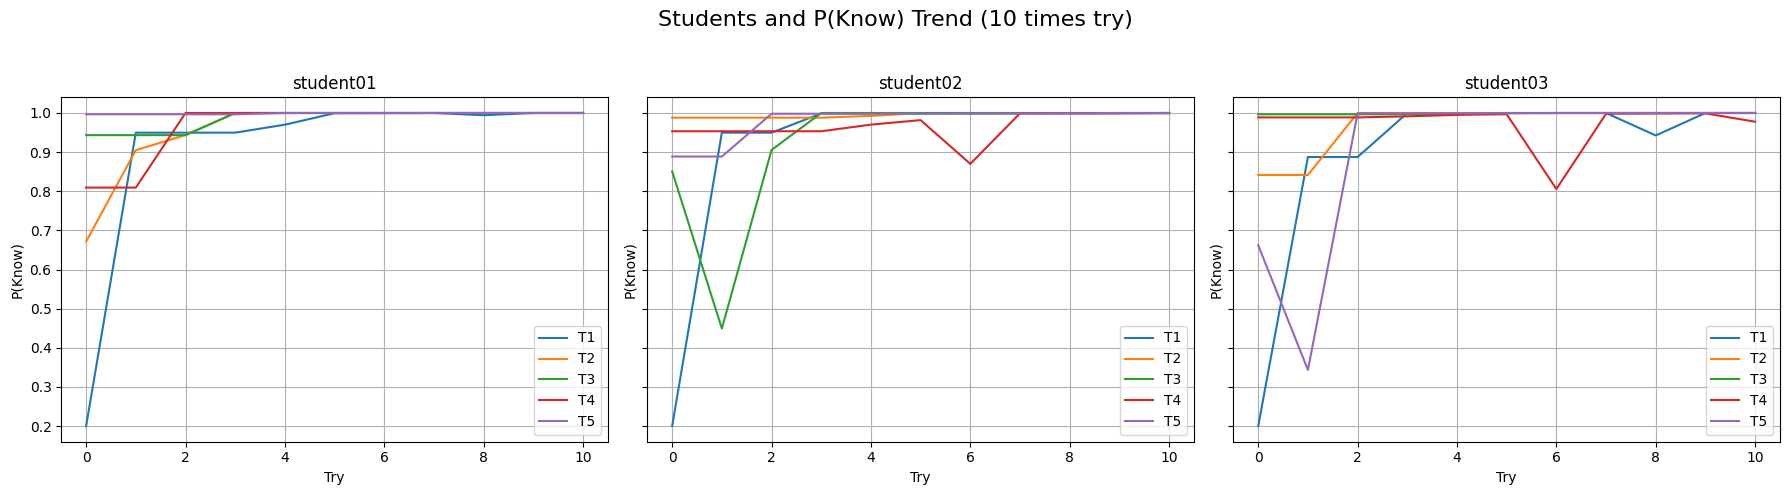

In [ ]:
import random
import matplotlib.pyplot as plt

# ----------------------------
# BKT 클래스 정의
# ----------------------------
class BKT:
    def __init__(self, p_init=0.2, p_learn=0.3, p_guess=0.2, p_slip=0.1):
        self.p_init = p_init
        self.p_learn = p_learn
        self.p_guess = p_guess
        self.p_slip = p_slip

    def update(self, p_know, is_correct):
        if is_correct:
            num = p_know * (1 - self.p_slip)
            den = num + (1 - p_know) * self.p_guess
        else:
            num = p_know * self.p_slip
            den = num + (1 - p_know) * (1 - self.p_guess)
        p_know_given_obs = num / den
        return p_know_given_obs + (1 - p_know_given_obs) * self.p_learn

# ----------------------------
# 문제 풀 생성
# ----------------------------
levels = ['상', '중', '하']
types = ['T1', 'T2', 'T3', 'T4', 'T5']
problems = [{'id': i, 'difficulty': random.choice(levels), 'type': random.choice(types)} for i in range(100)]

# ----------------------------
# 초기 진단 결과
# ----------------------------
student_knowledge = {
    'student01': {'T1': 0.2000, 'T2': 0.6715, 'T3': 0.9434, 'T4': 0.8094, 'T5': 0.9967},
    'student02': {'T1': 0.2000, 'T2': 0.9880, 'T3': 0.8508, 'T4': 0.9533, 'T5': 0.8887},
    'student03': {'T1': 0.2000, 'T2': 0.8416, 'T3': 0.9967, 'T4': 0.9887, 'T5': 0.6622},
}

difficulty_correct_prob = {'하': 0.9, '중': 0.6, '상': 0.3}
students = list(student_knowledge.keys())
bkt_model = BKT()

# ----------------------------
# 시뮬레이션 함수
# ----------------------------
def personalized_problem_simulation(student_id, knowledge_dict, num_rounds=10):
    history = {t: [knowledge_dict[t]] for t in types}

    for _ in range(num_rounds):
        # 약한 유형 2개 선택
        sorted_types = sorted(knowledge_dict, key=lambda t: knowledge_dict[t])
        weak1, weak2 = sorted_types[0], sorted_types[1]

        # 해당 유형 문제 출제
        weak1_problems = [p for p in problems if p['type'] == weak1]
        weak2_problems = [p for p in problems if p['type'] == weak2]
        selected = random.sample(weak1_problems, min(6, len(weak1_problems))) + \
                   random.sample(weak2_problems, min(4, len(weak2_problems)))
        random.shuffle(selected)

        # 문제 풀이 및 P(Know) 업데이트
        for p in selected:
            q_type = p['type']
            correct_prob = difficulty_correct_prob[p['difficulty']]
            is_correct = random.random() < correct_prob
            current_p = knowledge_dict[q_type]
            updated_p = bkt_model.update(current_p, is_correct)
            knowledge_dict[q_type] = updated_p

        # 상태 기록
        for t in types:
            history[t].append(knowledge_dict[t])

    return history

# ----------------------------
# 시뮬레이션 수행
# ----------------------------
student_histories = {}
for student in students:
    student_histories[student] = personalized_problem_simulation(student, student_knowledge[student].copy())

# ----------------------------
# 시각화
# ----------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for idx, student in enumerate(students):
    ax = axes[idx]
    for t in types:
        ax.plot(student_histories[student][t], label=t)
    ax.set_title(student)
    ax.set_xlabel("Try")
    ax.set_ylabel("P(Know)")
    ax.legend()
    ax.grid(True)

plt.suptitle("Students and P(Know) Trend (10 times try)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# <font color='orange'> **6. 서비스를 위하여**
- 학생별로 문제풀이 기록도 표로 출력
- 이 과정을 Streamlit 대시보드로 구현
- SQLite에 저장하여 학습 로그 관리



In [ ]:
! pip install gradio --quiet

In [ ]:
import sqlite3
import pandas as pd
import gradio as gr

# ----------------------------
# 학습 로그를 저장할 SQLite DB 초기화
# ----------------------------
def initialize_db():
    conn = sqlite3.connect("learning_log.db")
    cursor = conn.cursor()
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS logs (
            student_id TEXT,
            round INTEGER,
            problem_id INTEGER,
            type TEXT,
            difficulty TEXT,
            is_correct INTEGER,
            p_know_before REAL,
            p_know_after REAL
        )
    ''')
    conn.commit()
    conn.close()

# ----------------------------
# DB에 기록 저장 함수
# ----------------------------
def log_to_db(student_id, round_num, problem, is_correct, p_before, p_after):
    conn = sqlite3.connect("learning_log.db")
    cursor = conn.cursor()
    cursor.execute('''
        INSERT INTO logs (student_id, round, problem_id, type, difficulty, is_correct, p_know_before, p_know_after)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?)
    ''', (student_id, round_num, problem['id'], problem['type'], problem['difficulty'], int(is_correct), p_before, p_after))
    conn.commit()
    conn.close()

# ----------------------------
# 학습 시뮬레이션 + DB 기록
# ----------------------------
def simulate_learning_and_log(student_id, knowledge_dict, rounds=10):
    for round_num in range(1, rounds + 1):
        # 가장 약한 유형 2개 선택
        sorted_types = sorted(knowledge_dict, key=lambda t: knowledge_dict[t])
        weak1, weak2 = sorted_types[0], sorted_types[1]

        weak1_problems = [p for p in problems if p['type'] == weak1]
        weak2_problems = [p for p in problems if p['type'] == weak2]

        selected = random.sample(weak1_problems, min(6, len(weak1_problems))) + \
                   random.sample(weak2_problems, min(4, len(weak2_problems)))
        random.shuffle(selected)

        for p in selected:
            q_type = p['type']
            correct_prob = difficulty_correct_prob[p['difficulty']]
            is_correct = random.random() < correct_prob
            p_before = knowledge_dict[q_type]
            p_after = bkt_model.update(p_before, is_correct)
            knowledge_dict[q_type] = p_after

            log_to_db(student_id, round_num, p, is_correct, p_before, p_after)

# ----------------------------
# Gradio 대시보드 함수
# ----------------------------
def display_logs(student_id):
    conn = sqlite3.connect("learning_log.db")
    df = pd.read_sql_query(f"SELECT * FROM logs WHERE student_id='{student_id}'", conn)
    conn.close()
    return df

# ----------------------------
# 전체 실행 흐름
# ----------------------------
initialize_db()

# 초기 상태 복사
initial_knowledge = {
    'student01': {'T1': 0.2000, 'T2': 0.6715, 'T3': 0.9434, 'T4': 0.8094, 'T5': 0.9967},
    'student02': {'T1': 0.2000, 'T2': 0.9880, 'T3': 0.8508, 'T4': 0.9533, 'T5': 0.8887},
    'student03': {'T1': 0.2000, 'T2': 0.8416, 'T3': 0.9967, 'T4': 0.9887, 'T5': 0.6622},
}

for student in students:
    simulate_learning_and_log(student, initial_knowledge[student].copy())

# Gradio 인터페이스
demo = gr.Interface(
    fn=display_logs,
    inputs=gr.Dropdown(choices=students, label="학생 선택"),
    outputs=gr.Dataframe(label="문제 풀이 기록"),
    title="📊 학생별 문제풀이 로그 조회",
    description="학생을 선택하면 SQLite에 저장된 문제 풀이 기록을 확인할 수 있습니다."
)

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4e62b14863b8f47d4e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
